<a href="https://colab.research.google.com/github/melibrun/free-time/blob/main/%D0%AD%D0%BA%D0%B7%D0%B0%D0%BC%D0%B5%D0%BD_%D0%BF%D0%BE_%D1%8D%D0%BF%D0%B8%D0%B3%D0%B5%D0%BD%D0%BE%D0%BC%D0%B8%D0%BA%D0%B5_%D0%98%D0%B2%D0%B0%D0%BD%D0%BE%D0%B2%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача

Постройте UMAP embedding для клеток, определите кластеры, найдите маркерные гены, определяющие кластеры.

Нарисуйте:

UMAP embedding, раскраска по кластерам
Экспрессия генов на UMAP embedding: MKI67, COL1A1, CD3D, CD8A, CHGA и другие гены, которые покажутся вам интересными.
dotplot c генами-маркерами кластеров

## Загрузка библиотек

In [ ]:
install.packages('Seurat')
# Установка нужных библиотек.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘sass’, ‘BH’, ‘sitmo’, ‘globals’, ‘listenv’, ‘parallelly’, ‘plyr’, ‘zoo’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘here’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘httpuv’, ‘xtable’, ‘fontawesome’, ‘sourcetools’, ‘later’, ‘bslib’, ‘spatstat.data’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘abind’, ‘tensor’, ‘goftest’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘RSpectra’, ‘dqrng’, ‘cowplot’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘leiden’, ‘lmtest’, ‘matrixStats’, ‘miniUI’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘RANN’, ‘RcppAnnoy’, ‘reticulate’, ‘ROCR’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘SeuratObject’, ‘shiny’, ‘spatstat.core’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’




In [ ]:
library(Seurat)

library(ggplot2)
library(dplyr)

# Seurat is an R package designed for QC, analysis, and exploration of single-cell RNA-seq data.
# ggplot2 is an open-source data visualization package for the statistical programming language R.
# dplyr is one of the core packages of the tidyverse (tidy data) in the R programming language

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Загрузка данных

Датасет: GSM4654673


https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4654673



In [ ]:
# Сохраняем все три таблицы в GSM4654672/
dir.create('GSM4654673/', showWarnings=F)

# barcodes
download.file('https://adameykolab.srv.meduniwien.ac.at/share/teaching/scRNAseq/neuroblastoma/GSM4654673/barcodes.tsv.gz', 'GSM4654673/barcodes.tsv.gz')

# features
download.file('https://adameykolab.srv.meduniwien.ac.at/share/teaching/scRNAseq/neuroblastoma/GSM4654673/features.tsv.gz', 'GSM4654673/features.tsv.gz')

# matrix
download.file('https://adameykolab.srv.meduniwien.ac.at/share/teaching/scRNAseq/neuroblastoma/GSM4654673/matrix.mtx.gz', 'GSM4654673/matrix.mtx.gz')

## Запуск анализа Seurat — с клеточным циклом

In [ ]:
# Загрузка данных и создание объекта Seurat
path = 'GSM4654673/'
project_name = 'T200'

data = Read10X(path)
SR = CreateSeuratObject(counts = data, project = project_name, min.cells = 3, min.features = 200)
SR

An object of class Seurat 
21854 features across 10280 samples within 1 assay 
Active assay: RNA (21854 features, 0 variable features)

Для решения задачи это не нужно, но пусть будет, красиво же:

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


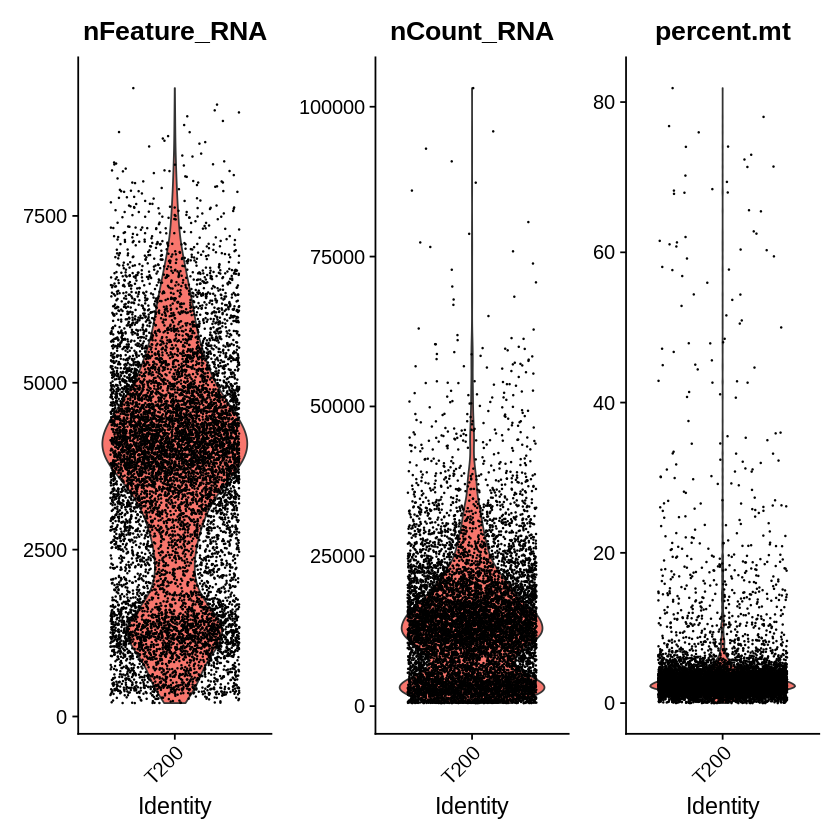

An object of class Seurat 
21854 features across 9978 samples within 1 assay 
Active assay: RNA (21854 features, 0 variable features)

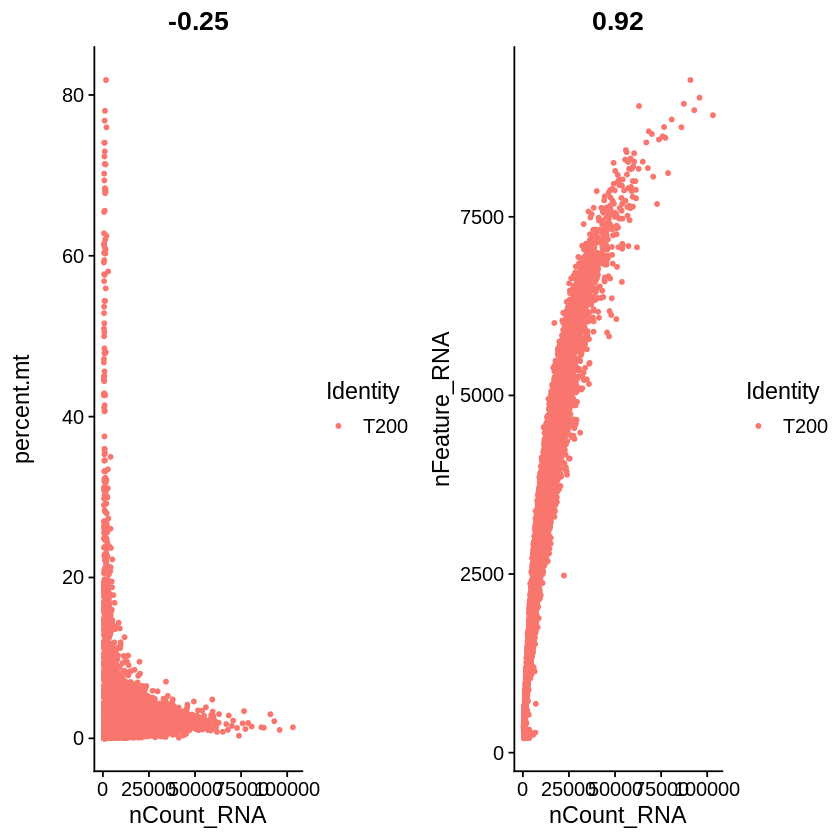

In [ ]:
# Оценка % митохондриальной РНК
SR[["percent.mt"]] <- PercentageFeatureSet(SR, pattern = "^MT-")

# Построение графика для mtRNA и totalRNA
VlnPlot(SR, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
plot1 <- FeatureScatter(SR, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(SR, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot(CombinePlots(plots = list(plot1, plot2)))

# Фильтрация клеток
SR <- subset(SR, subset = nFeature_RNA > 200 & nFeature_RNA < 7000 & percent.mt < 25)
SR

In [ ]:
# Нормализация данных
SR <- NormalizeData(SR)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "APOE"     "CCL19"    "APOC1"    "HLA-DRA"  "IGFBP5"   "MMP9"    
 [7] "IGFBP7"   "CD74"     "LYZ"      "C1QA"     "HLA-DRB1" "TIMP1"   
[13] "HLA-DPA1" "C1QC"     "PTGDS"    "FUCA1"    "COL1A1"   "GNLY"    
[19] "HLA-DPB1" "SELENOP"

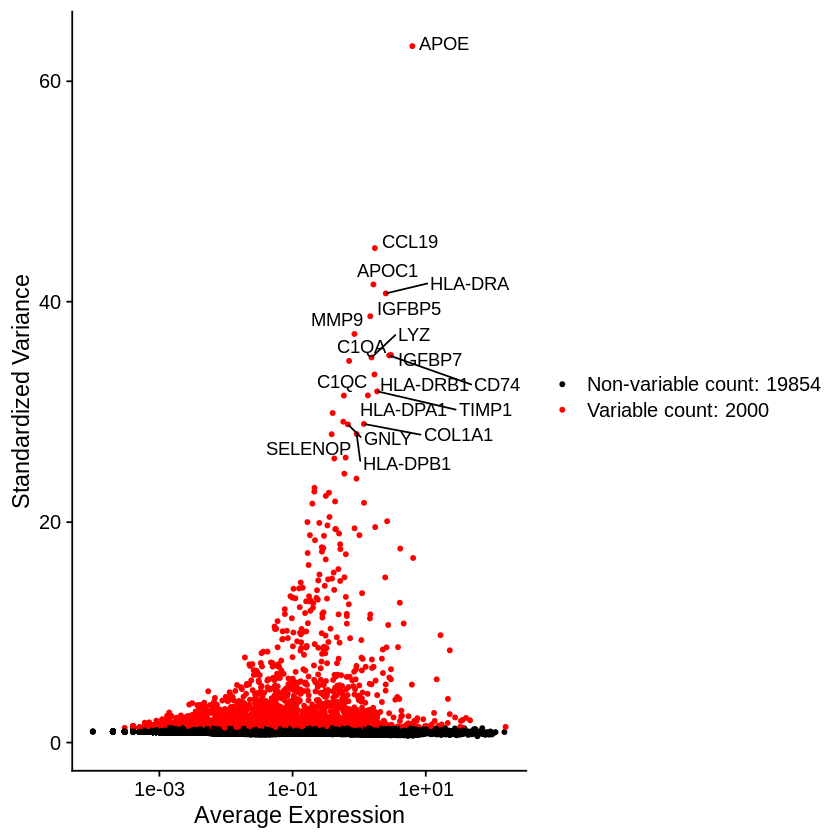

In [ ]:
# Поиск вариабельных генов
SR <- FindVariableFeatures(SR, selection.method = "vst", nfeatures = 2000)
top10 <- head(VariableFeatures(SR), 20)
plot1 <- VariableFeaturePlot(SR)
plot(LabelPoints(plot = plot1, points = top10, repel = TRUE))

top10

In [ ]:
# Регрессия данных:
SR <- ScaleData(SR, vars.to.regress = c("nFeature_RNA", "nCount_RNA", "percent.mt"))

Regressing out nFeature_RNA, nCount_RNA, percent.mt

Centering and scaling data matrix



#Уменьшение размерности: PCA

PC_ 1 
Positive:  SPARC, COL4A1, IGFBP7, IFITM3, LGALS1, COL4A2, COL18A1, COL6A2, CAVIN3, CALD1 
	   CAVIN1, A2M, SPARCL1, SERPINH1, TIMP1, FN1, EVA1B, COL1A2, BGN, COL1A1 
	   GSN, VIM, UACA, CAV1, GNG11, RRAS, S100A11, PDLIM1, MYL9, MYLK 
Negative:  TUBB2B, CKB, GAP43, STMN1, PRPH, JPT1, MEG3, TUBB2A, CHGB, MAP1B 
	   NEFM, TUBA1A, PCDH9, TUBB, SCG2, CCND1, INSM2, ZFHX4, NEFL, HMGN2 
	   MYEF2, NASP, CKS1B, UBE2T, SFPQ, MCM7, PEG10, COCH, BUB3, MZT1 
PC_ 2 
Positive:  LYZ, HLA-DQA1, HLA-DRA, HLA-DRB1, HLA-DPA1, TYROBP, CD74, CD68, HLA-DQB1, C1QA 
	   HLA-DMA, HLA-DQA2, MS4A6A, IGSF6, C1QC, HLA-DRB5, HLA-DMB, C1QB, CSF1R, MMP9 
	   CYBB, FGL2, IL18, AIF1, HLA-DPB1, CD14, SPI1, ADAMDEC1, SERPINA1, CSF2RA 
Negative:  COL4A1, CALD1, COL4A2, COL1A2, COL1A1, IGFBP7, FN1, COL18A1, THY1, BGN 
	   MYL9, CAVIN1, PLAC9, CAVIN3, MYLK, COL5A2, SELENOM, COL3A1, TPM2, NR2F2 
	   PDGFRB, NNMT, PRRX1, SPARCL1, UACA, SERPINH1, CAV1, LHFPL6, C1R, PDGFA 
PC_ 3 
Positive:  NUSAP1, TOP2A, MKI67, GTSE1, NU

PC_ 1 
Positive:  SPARC, COL4A1, IGFBP7, IFITM3, LGALS1 
Negative:  TUBB2B, CKB, GAP43, STMN1, PRPH 
PC_ 2 
Positive:  LYZ, HLA-DQA1, HLA-DRA, HLA-DRB1, HLA-DPA1 
Negative:  COL4A1, CALD1, COL4A2, COL1A2, COL1A1 
PC_ 3 
Positive:  NUSAP1, TOP2A, MKI67, GTSE1, NUF2 
Negative:  HIST3H2A, ECEL1, PRPH, MEG3, CHGB 
PC_ 4 
Positive:  TUBB2B, TMEM176B, CST3, TUBB, APOE 
Negative:  LTB, CD3D, CXCR4, CD3E, KLF2 
PC_ 5 
Positive:  EMP3, S100A4, LTB, COL1A1, COL1A2 
Negative:  VWF, SOX18, EGFL7, PLVAP, CD93 


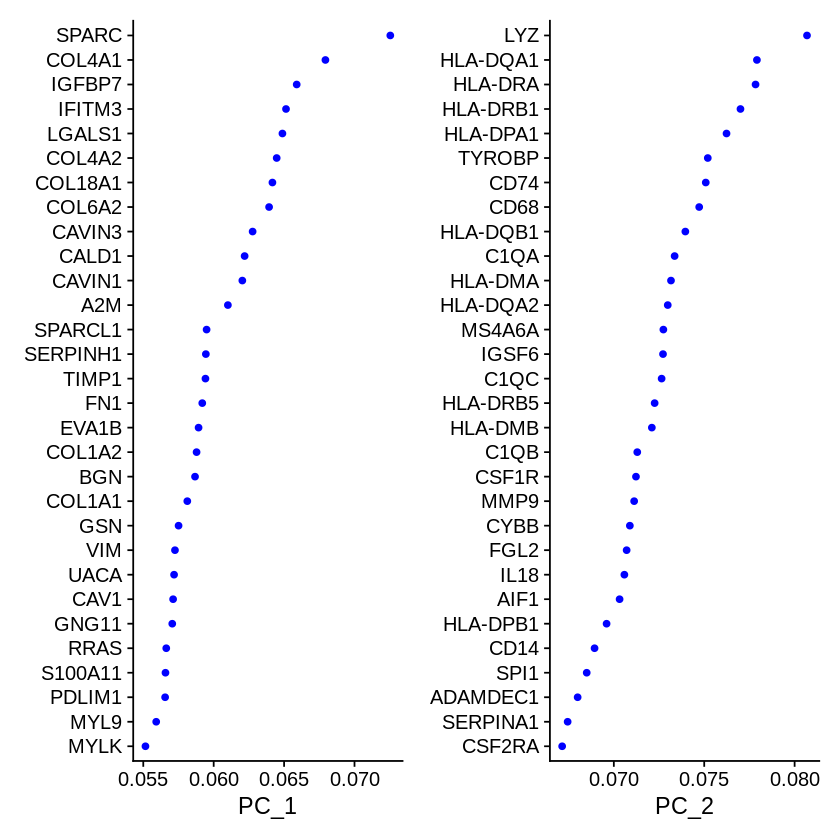

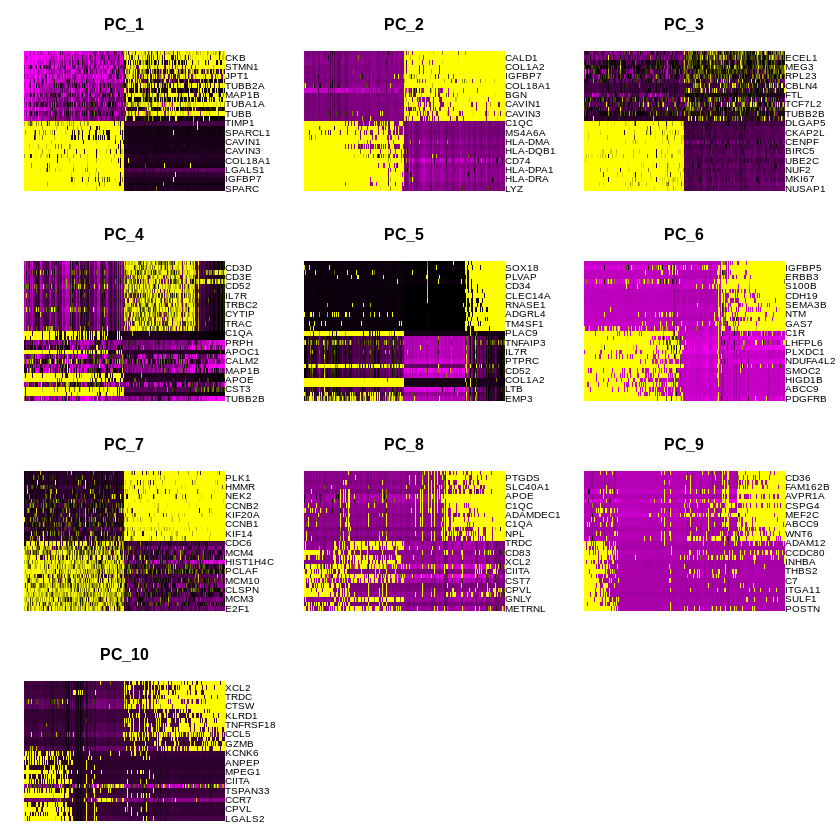

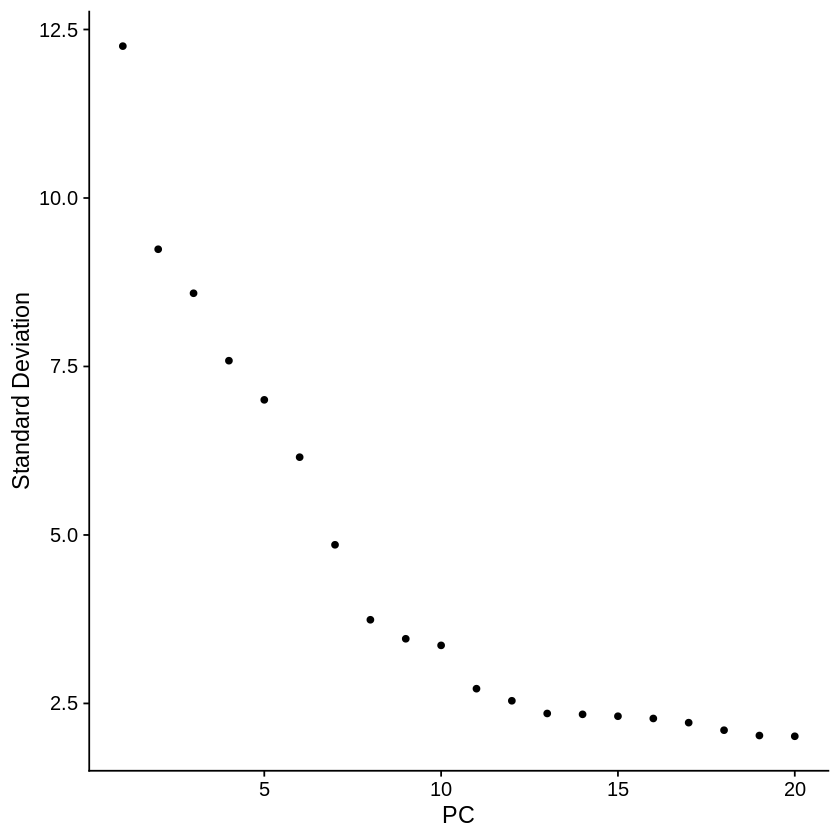

In [ ]:

# ElbowPlot — считаем k-means ("How many principal components to take?")
SR <- RunPCA(SR, features = VariableFeatures(object = SR))
print(SR[["pca"]], dims = 1:5, nfeatures = 5)
plot(VizDimLoadings(SR, dims = 1:2, reduction = "pca"))

DimHeatmap(SR, dims = 1:10, cells = 500, balanced = TRUE)

SR <- JackStraw(SR, num.replicate = 100)
SR <- ScoreJackStraw(SR, dims = 1:20)
plot(ElbowPlot(SR))



#Кластеризация и использование UMAP 

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9978
Number of edges: 312479

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9103
Number of communities: 17
Elapsed time: 1 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
07:29:44 UMAP embedding parameters a = 0.9922 b = 1.112

07:29:44 Read 9978 rows and found 15 numeric columns

07:29:44 Using Annoy for neighbor search, n_neighbors = 30

07:29:44 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:29:45 Writing NN index file to temp file /tmp/RtmpAxtfcp/file3f2496752d

07:29:45 Searching Annoy index using 1 thread, search_k = 3000

07:29:50 Annoy recall = 100%

07:29:50 Commencing smooth kNN distance calibration using 1 thread

07:29:51 Initializing from 

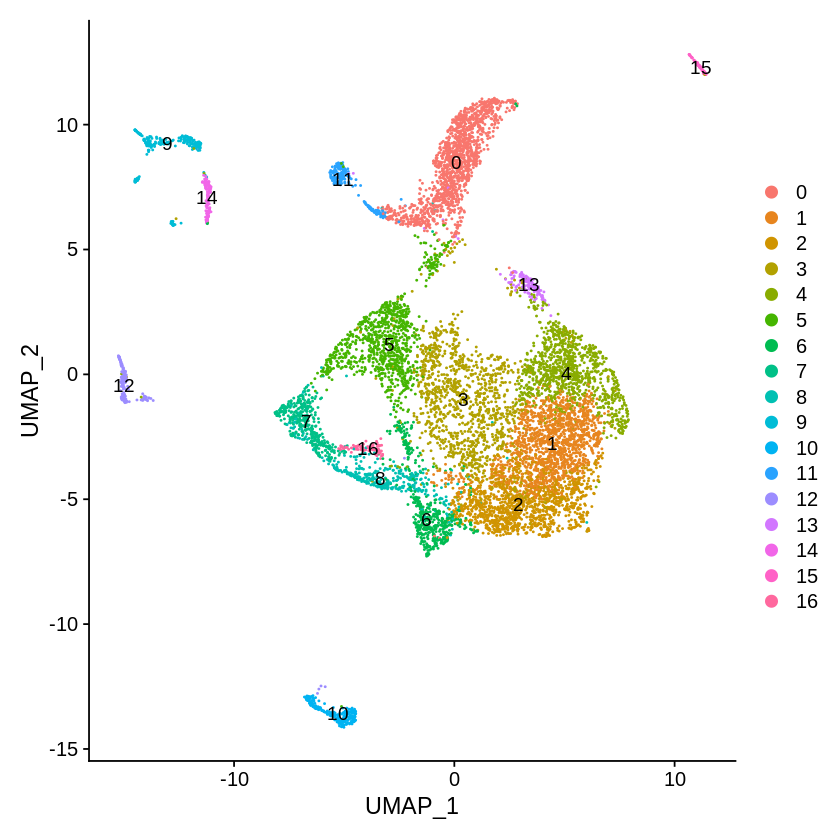

In [ ]:

## Ищем ближайших соседей для каждой клетки => граф
## кластеризация
## запускаем UMAP
# UMAP — алгоритм ML, выполняющий нелинейное снижение размерности (Uniform Manifold Approximation and Projection)

SR <- FindNeighbors(SR, dims = 1:10)
SR <- FindClusters(SR, resolution = 0.5)
SR <- RunUMAP(SR, dims = 1:15)
DimPlot(SR, reduction = "umap", label=T)

# Поиск маркерных генов для каждого кластера и визуализация

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16



myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.979,3.1749041,0.958,4.5804184,0.982,0.142,0,LTB
0.951,2.1518064,0.902,3.1044004,0.928,0.068,0,CD3D
0.944,1.8088337,0.888,2.6095954,0.972,0.793,0,BTG1
0.939,1.8142026,0.878,2.6173411,0.999,0.823,0,B2M
0.931,1.7601871,0.862,2.5394132,0.978,0.221,0,HLA-C
0.763,0.5073819,0.526,0.7319974,1.000,0.816,1,STMN2
0.755,0.4854486,0.510,0.7003543,0.999,0.717,1,PRPH
0.747,0.3657383,0.494,0.5276489,1.000,0.935,1,HSP90AB1
0.746,0.4996731,0.492,0.7208759,1.000,0.731,1,PHOX2A


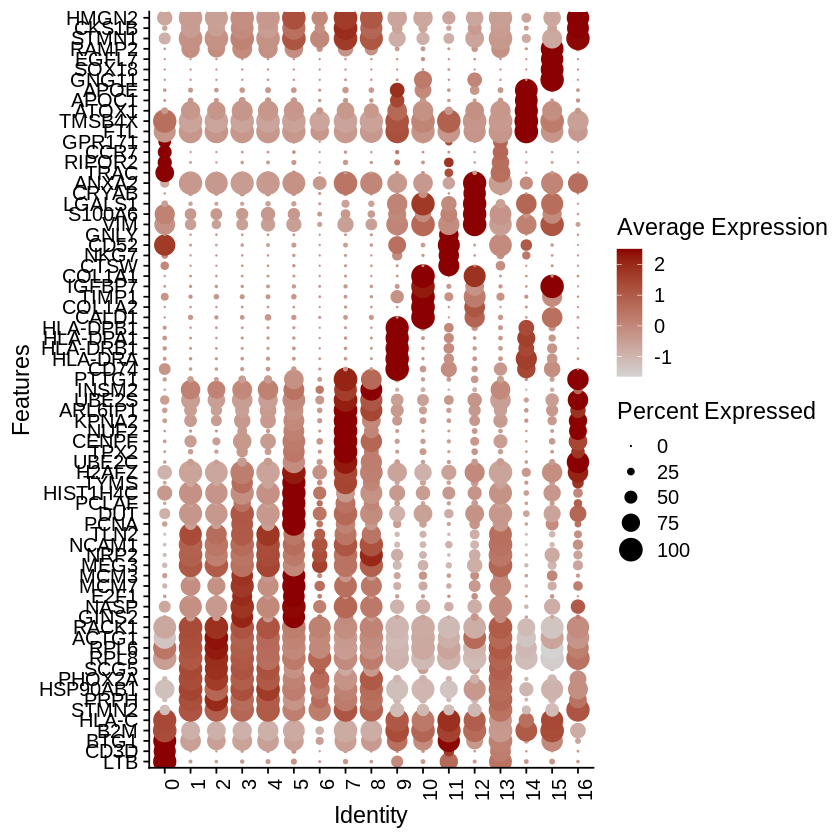

In [ ]:


SR.markers.AUC <- FindAllMarkers(SR, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, test='roc')
library(dplyr)
top5 <- SR.markers.AUC %>% group_by(cluster) %>% top_n(n = 5, wt = myAUC)

DotPlot(SR, features = unique(top5$gene), cols = c("lightgrey", "darkred"))+
         coord_flip()+theme(axis.text.x = element_text(angle = 90, hjust = 1))

top5



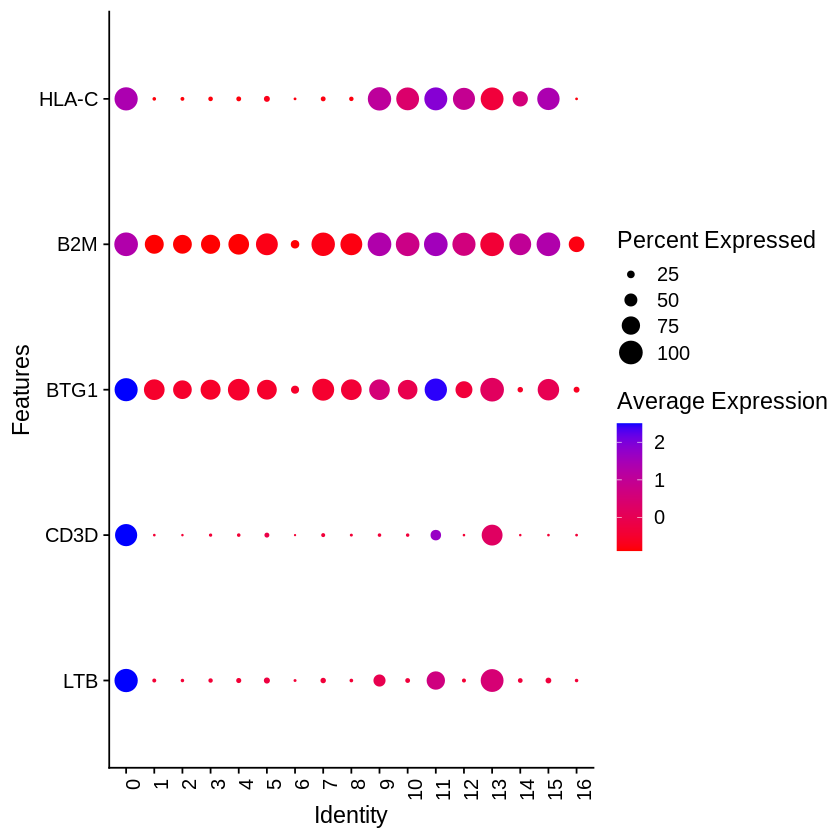

In [ ]:
DotPlot(SR, features = unique(top5$gene[1:5]), cols = c("red", "blue"))+
         coord_flip()+theme(axis.text.x = element_text(angle = 90, hjust = 1))

#Визуализация маркеров:  
COL1A1, CD3D, CD8A, CHGA 

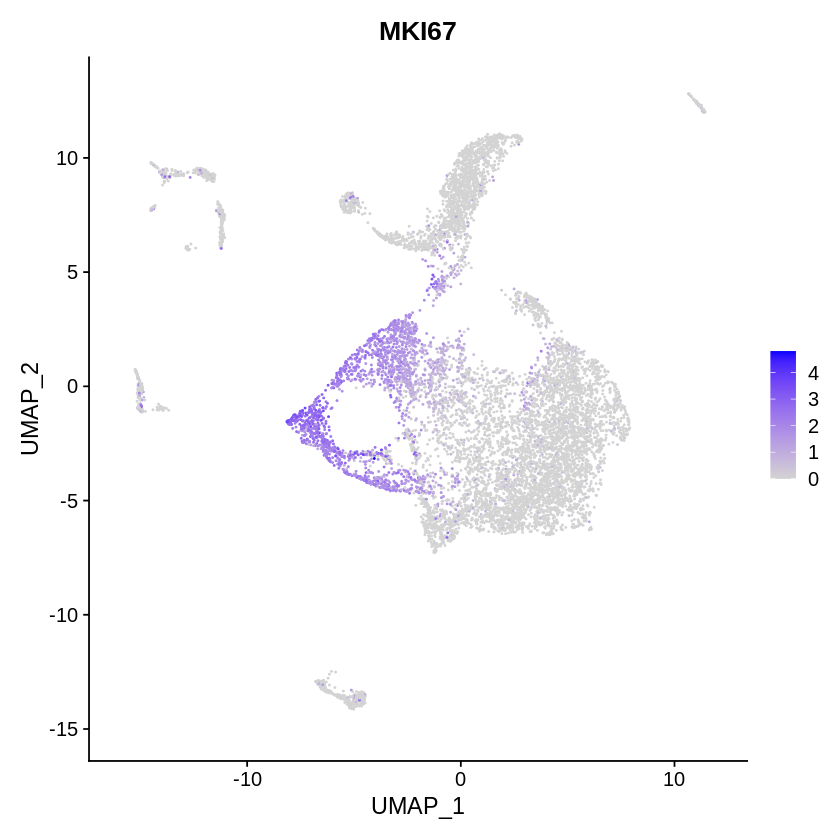

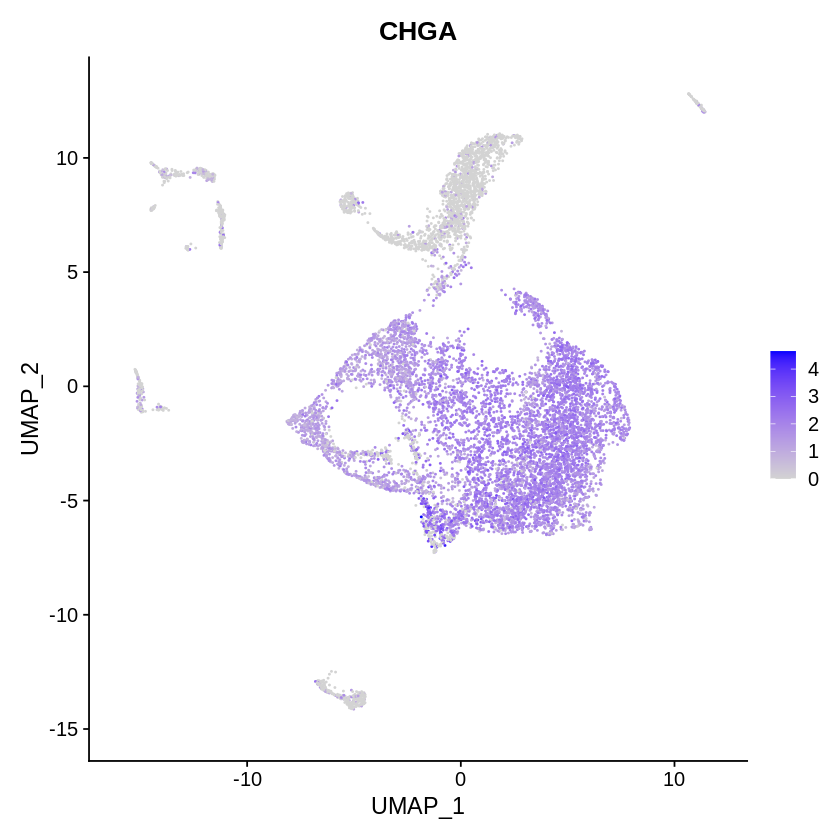

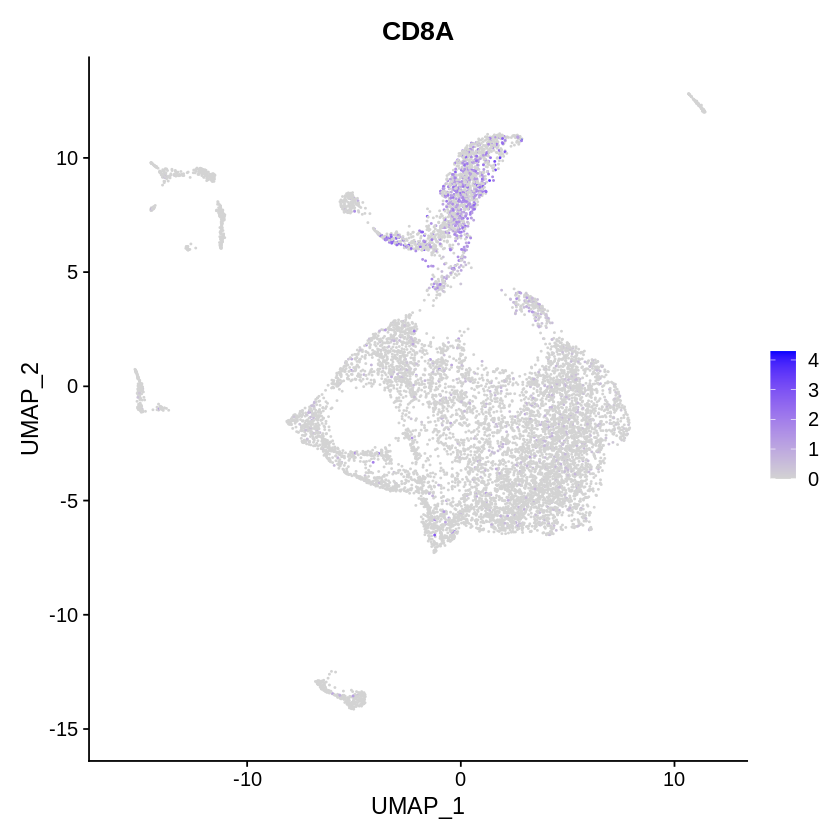

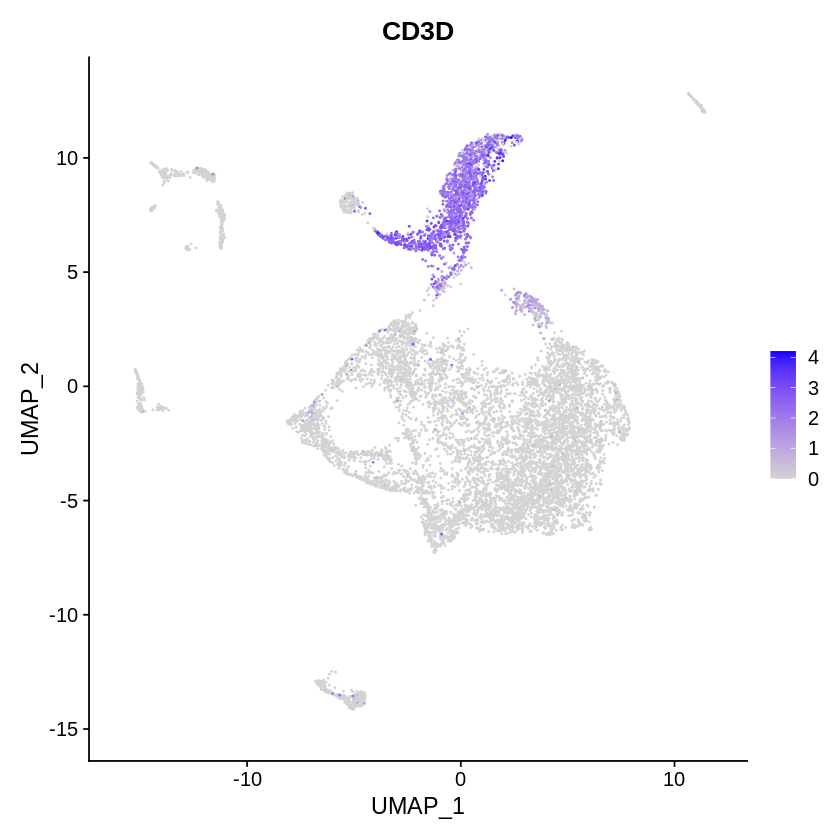

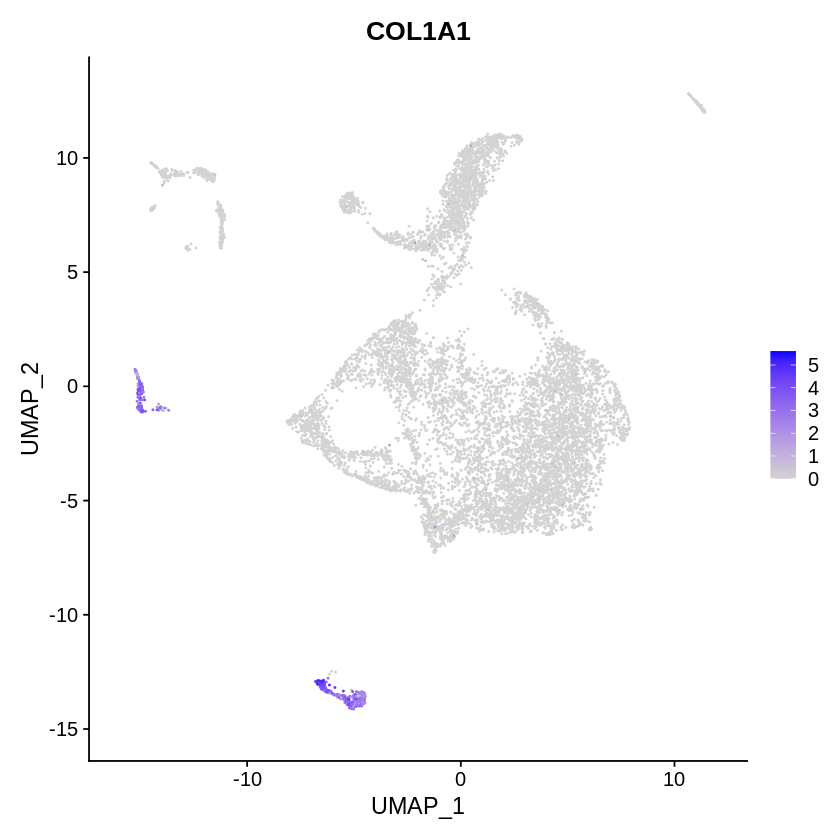

In [ ]:
FeaturePlot(SR, 'MKI67') 
FeaturePlot(SR, 'CHGA') 
FeaturePlot(SR, 'CD8A')
FeaturePlot(SR, 'CD3D')
FeaturePlot(SR, 'COL1A1')
